<h1 style='text-align: center;'>TP2</h1>
<h1 style='text-align: center;'>Reconnaissance Chien / Chat</h1>

##  Connexion de Kaggle à Google Colab et téléchargement à partir de Kaggle vers le serveur de Google Colab.

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

100% 787M/787M [00:05<00:00, 183MB/s]
100% 787M/787M [00:05<00:00, 140MB/s]


## Décompressez le jeu de données installé.

In [ ]:
!unzip /content/kaggle-cat-vs-dog-dataset.zip
!mkdir /content/PetImages

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5489.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/549.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5490.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5491.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5492.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5493.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5494.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5495.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5496.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5497.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5498.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5499.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/55.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/550.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5500.jp

## Déplacement des images vers un seul répertoire.

In [ ]:
import os
for image in os.listdir('/content/kagglecatsanddogs_3367a/PetImages/Cat'):
    os.rename('/content/kagglecatsanddogs_3367a/PetImages/Cat/'+image,'/content/PetImages/'+'cat_'+image)

In [ ]:
for image in os.listdir('/content/kagglecatsanddogs_3367a/PetImages/Dog'):
    os.rename('/content/kagglecatsanddogs_3367a/PetImages/Dog/'+image,'/content/PetImages/'+'dog_'+image)

## les différentes bibliothèques utilisées.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pandas as pd

import tensorflow as tf
import keras


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from keras.preprocessing.image import ImageDataGenerator


from pathlib import Path


from sklearn.utils import class_weight as cw
from sklearn.utils.class_weight import compute_class_weight
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Dropout

from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

from keras.utils import to_categorical

from tensorflow.keras.utils import load_img

import random


# Déclaration des constantes

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=15
PATH_IMAGES="/content/PetImages/"


# Création d'une dataframe avec le nom de fichier et la catégorie.

In [ ]:
filenames = []
categories = []
for filename in os.listdir(PATH_IMAGES):
  filenames.append(filename)
  categories.append(filename.split('_')[0])


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df

,filename,category
0,cat_7463.jpg,cat
1,dog_11060.jpg,dog
2,cat_4619.jpg,cat
3,cat_7954.jpg,cat
4,cat_1292.jpg,cat
...,...,...
24956,dog_7562.jpg,dog
24957,dog_3713.jpg,dog
24958,cat_9561.jpg,cat
24959,cat_6784.jpg,cat


<Axes: >

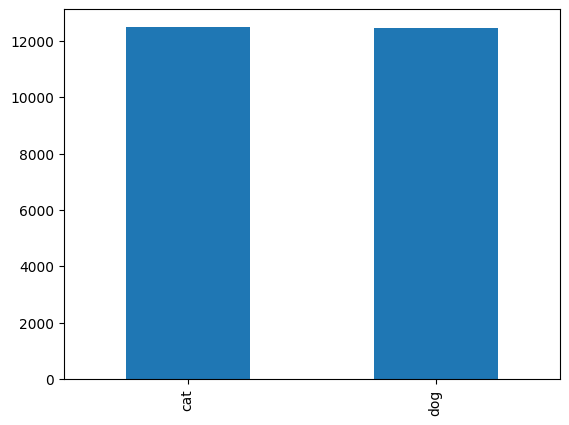

In [ ]:
df['category'].value_counts().plot.bar()

# Visualisation des images

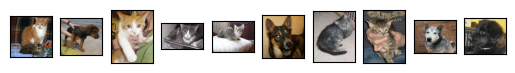

In [ ]:
for i in range(10):
      ax = plt.subplot(1, 10, i+1)
      image = load_img(PATH_IMAGES+filenames[i])
      plt.imshow(image)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#df["category"] = df["category"].replace({'cat':0, 'dog':1})
df

,filename,category
0,cat_7463.jpg,cat
1,dog_11060.jpg,dog
2,cat_4619.jpg,cat
3,cat_7954.jpg,cat
4,cat_1292.jpg,cat
...,...,...
24956,dog_7562.jpg,dog
24957,dog_3713.jpg,dog
24958,cat_9561.jpg,cat
24959,cat_6784.jpg,cat


# Séparation de jeux de données d'entraînement et de test.

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df

,filename,category
0,dog_8466.jpg,dog
1,cat_7749.jpg,cat
2,cat_4454.jpg,cat
3,cat_11350.jpg,cat
4,cat_3828.jpg,cat
...,...,...
19963,cat_6502.jpg,cat
19964,cat_9799.jpg,cat
19965,dog_10179.jpg,dog
19966,dog_12153.jpg,dog


# Augmentation des images

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/PetImages",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 19966 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/PetImages",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 4993 validated image filenames belonging to 2 classes.


# Visualisation des augmentations de données à partir du générateur de données d'images de Keras.

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/PetImages",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


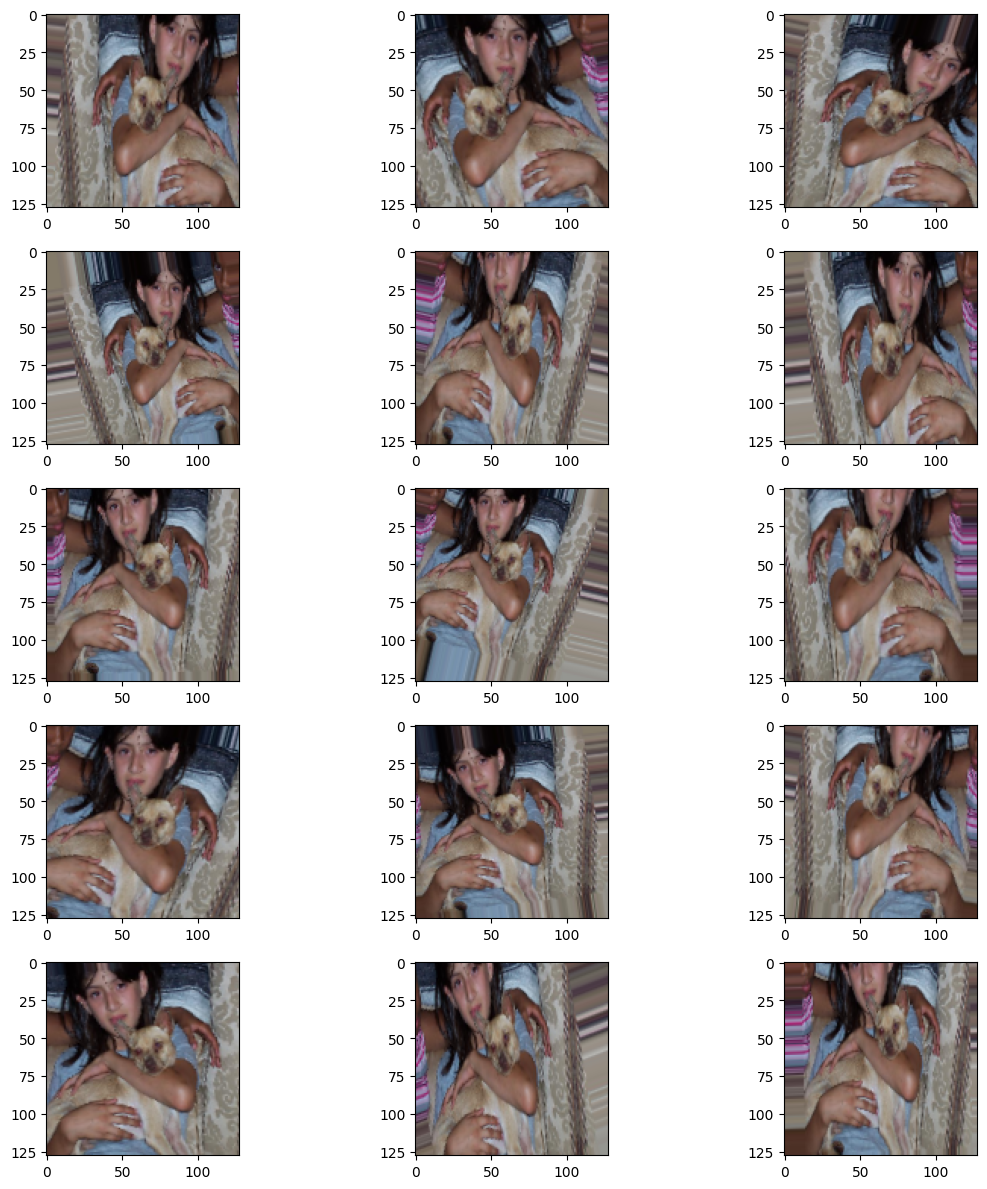

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Création du Modèle de convolution

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Ce code met en place deux rappels (callbacks) pour améliorer l'entraînement d'un modèle

In [ ]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Entrainement du modèle et évaluation

In [ ]:
epochs=3 if FAST_RUN else 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
 566/1331 [===========>..................] - ETA: 1:11 - loss: 0.7062 - accuracy: 0.6261

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1331/1331 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.6639

1331/1331 [==============================] - 177s 133ms/step - loss: 0.6451 - accuracy: 0.6639 - val_loss: 0.5608 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 2/20
1331/1331 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7272

1331/1331 [==============================] - 132s 99ms/step - loss: 0.5526 - accuracy: 0.7272 - val_loss: 0.4996 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 3/20
1331/1331 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.7604

1331/1331 [==============================] - 131s 98ms/step - loss: 0.5007 - accuracy: 0.7604 - val_loss: 0.5981 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 4/20
1331/1331 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.7897

1331/1331 [==============================] - 130s 98ms/step - loss: 0.4580 - accuracy: 0.7897 - val_loss: 0.4608 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 5/20
1331/1331 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8038

1331/1331 [==============================] - 130s 97ms/step - loss: 0.4299 - accuracy: 0.8038 - val_loss: 1.3903 - val_accuracy: 0.5795 - lr: 0.0010
Epoch 6/20
1331/1331 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.8132

1331/1331 [==============================] - 127s 96ms/step - loss: 0.4111 - accuracy: 0.8132 - val_loss: 0.4658 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 7/20
1331/1331 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8197

1331/1331 [==============================] - 135s 101ms/step - loss: 0.4017 - accuracy: 0.8197 - val_loss: 0.3301 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 8/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8294

1331/1331 [==============================] - 131s 98ms/step - loss: 0.3862 - accuracy: 0.8294 - val_loss: 0.3083 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 9/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8354

1331/1331 [==============================] - 132s 99ms/step - loss: 0.3770 - accuracy: 0.8354 - val_loss: 0.3605 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 10/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8409

1331/1331 [==============================] - 129s 97ms/step - loss: 0.3663 - accuracy: 0.8409 - val_loss: 0.2999 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 11/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3577 - accuracy: 0.8425

1331/1331 [==============================] - 127s 95ms/step - loss: 0.3577 - accuracy: 0.8425 - val_loss: 0.3300 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 12/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8463

1331/1331 [==============================] - 132s 99ms/step - loss: 0.3505 - accuracy: 0.8463 - val_loss: 0.2664 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 13/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8494

1331/1331 [==============================] - 129s 97ms/step - loss: 0.3472 - accuracy: 0.8494 - val_loss: 0.2861 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 14/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8512

1331/1331 [==============================] - 132s 99ms/step - loss: 0.3355 - accuracy: 0.8512 - val_loss: 0.3294 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 15/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.8532

1331/1331 [==============================] - 128s 96ms/step - loss: 0.3375 - accuracy: 0.8532 - val_loss: 0.3089 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 16/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8592

1331/1331 [==============================] - 129s 97ms/step - loss: 0.3299 - accuracy: 0.8592 - val_loss: 0.3828 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 17/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8567

1331/1331 [==============================] - 130s 98ms/step - loss: 0.3335 - accuracy: 0.8567 - val_loss: 0.3753 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 18/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8631

1331/1331 [==============================] - 129s 97ms/step - loss: 0.3241 - accuracy: 0.8631 - val_loss: 0.2805 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 19/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8651

1331/1331 [==============================] - 129s 97ms/step - loss: 0.3182 - accuracy: 0.8651 - val_loss: 0.2689 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 20/20
1331/1331 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8644

1331/1331 [==============================] - 133s 100ms/step - loss: 0.3146 - accuracy: 0.8644 - val_loss: 0.2982 - val_accuracy: 0.8755 - lr: 0.0010


# Affichage des courbes d'apprentissages

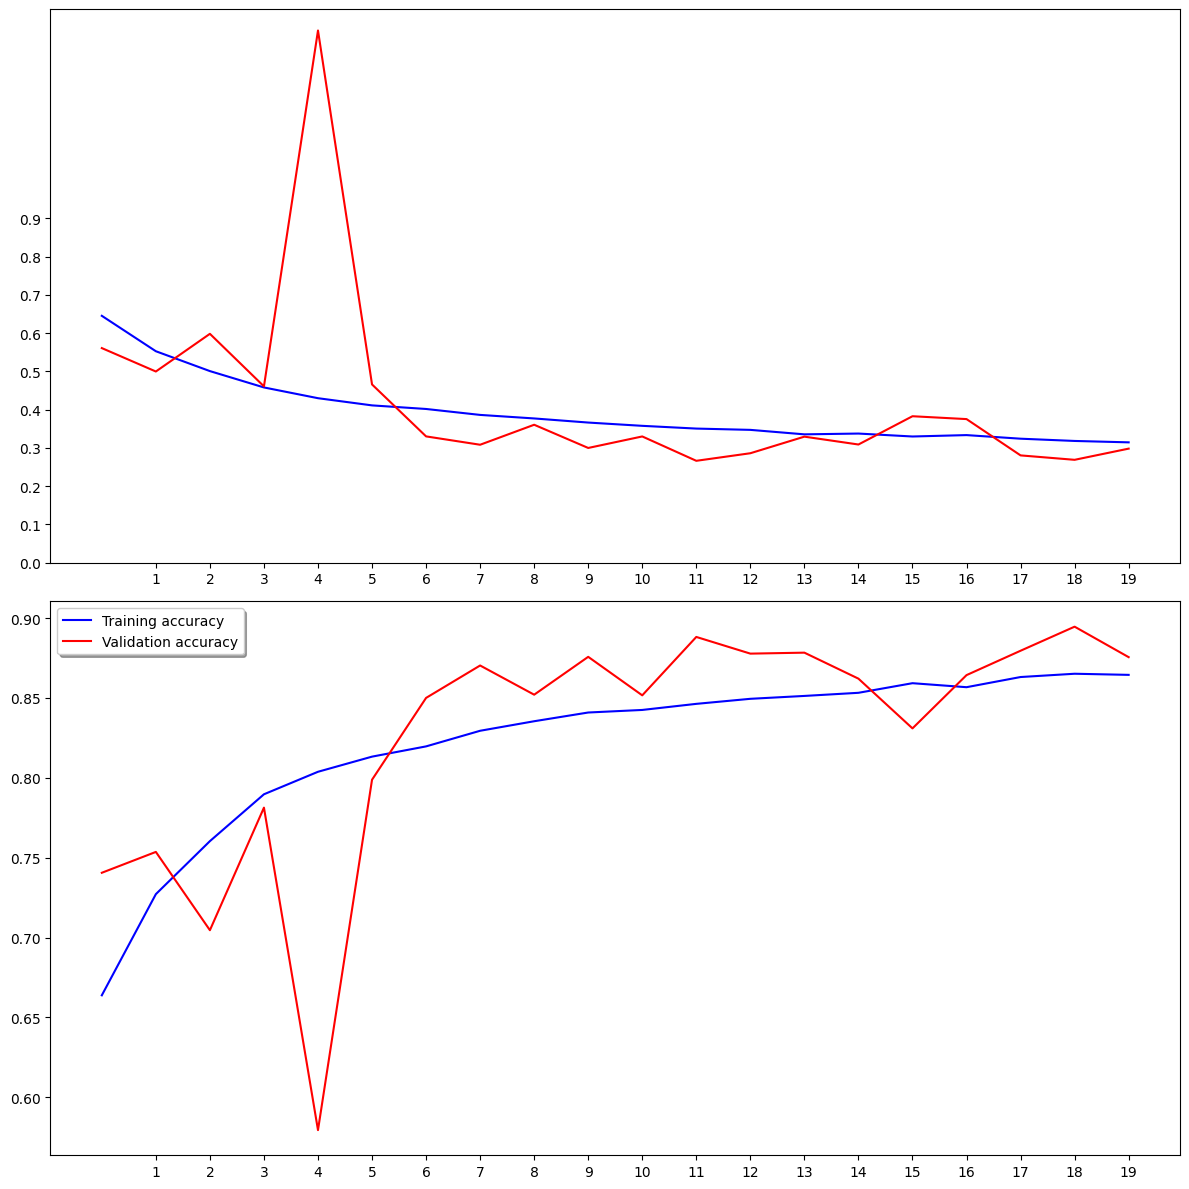

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    validate_df,
    "/content/PetImages",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4993 validated image filenames.


In [ ]:
validate_df.shape[0]

4993

In [ ]:
nb_samples = validate_df.shape[0]
predict = model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))
validate_df['category_predicted'] = np.argmax(predict, axis=-1)

333/333 [==============================] - 20s 28ms/step


In [ ]:
validate_df["category"] = validate_df["category"].replace({'cat':0, 'dog':1})

# Affichage du Matrice de confusion

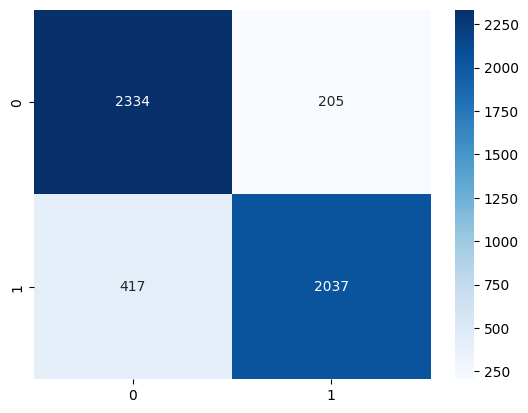

In [ ]:
cm = confusion_matrix(validate_df["category"],validate_df['category_predicted'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()